In [30]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [ ]:
# Version check
import google.protobuf

print("TF:", tf.__version__)
print("TFDS:", tfds.__version__)
print("protobuf:", google.protobuf.__version__)


In [31]:
# Dataset load with 80/20 split
(train_ds, val_ds), info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],  # 80% train, 20% validation
    with_info=True,
    as_supervised=True
)

num_classes = info.features["label"].num_classes
print("Number of classes:", num_classes)


Number of classes: 5


In [ ]:
# Preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

# For training
def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # EfficientNet preprocessing
    return image, label

# Apply preprocessing, shuffle, and batch
train_ds = train_ds.map(format_example).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Visualization of sample images
# Take one batch from the dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    
    for i in range(9):  # show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())  # convert Tensor to NumPy for plotting
        plt.title(int(labels[i].numpy()))  # show class index as title
        plt.axis("off")


In [33]:
# Build Functional model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base model

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)   # EfficientNet feature extractor
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_____________________________________________

In [34]:
# Callbacks
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=True)
]


In [35]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
92/92 [==============================] - 90s 924ms/step - loss: 1.5281 - accuracy: 0.3430 - val_loss: 1.2250 - val_accuracy: 0.6185
Epoch 2/10
92/92 [==============================] - 86s 933ms/step - loss: 1.1760 - accuracy: 0.5685 - val_loss: 0.9735 - val_accuracy: 0.7398
Epoch 3/10
92/92 [==============================] - 89s 965ms/step - loss: 0.9668 - accuracy: 0.6805 - val_loss: 0.8162 - val_accuracy: 0.8038
Epoch 4/10
92/92 [==============================] - 92s 998ms/step - loss: 0.8447 - accuracy: 0.7292 - val_loss: 0.7110 - val_accuracy: 0.8270
Epoch 5/10
92/92 [==============================] - 91s 995ms/step - loss: 0.7381 - accuracy: 0.7783 - val_loss: 0.6371 - val_accuracy: 0.8488
Epoch 6/10
92/92 [==============================] - 89s 970ms/step - loss: 0.6750 - accuracy: 0.7851 - val_loss: 0.5818 - val_accuracy: 0.8610
Epoch 7/10
92/92 [==============================] - 89s 971ms/step - loss: 0.6170 - accuracy: 0.8116 - val_loss: 0.5382 - val_accuracy: 0.8651

In [43]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze all except last 50
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune training
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
92/92 [==============================] - 129s 1s/step - loss: 0.4380 - accuracy: 0.8621 - val_loss: 0.3493 - val_accuracy: 0.8992
Epoch 2/10
92/92 [==============================] - 117s 1s/step - loss: 0.3714 - accuracy: 0.8791 - val_loss: 0.2998 - val_accuracy: 0.9142
Epoch 3/10
92/92 [==============================] - 117s 1s/step - loss: 0.3251 - accuracy: 0.8961 - val_loss: 0.2675 - val_accuracy: 0.9196
Epoch 4/10
92/92 [==============================] - 122s 1s/step - loss: 0.2756 - accuracy: 0.9094 - val_loss: 0.2451 - val_accuracy: 0.9223
Epoch 5/10
92/92 [==============================] - 121s 1s/step - loss: 0.2513 - accuracy: 0.9176 - val_loss: 0.2274 - val_accuracy: 0.9237
Epoch 6/10
92/92 [==============================] - 121s 1s/step - loss: 0.2246 - accuracy: 0.9275 - val_loss: 0.2130 - val_accuracy: 0.9264
Epoch 7/10
92/92 [==============================] - 121s 1s/step - loss: 0.2092 - accuracy: 0.9281 - val_loss: 0.2019 - val_accuracy: 0.9292
Epoch 8/10
92

In [ ]:
# Data Augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Rebuild with augmentation
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
augmented_model = models.Model(inputs, outputs)

augmented_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train again with augmentation
history_aug = augmented_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


In [44]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")


23/23 [==============================] - 19s 805ms/step - loss: 0.1777 - accuracy: 0.9360
Validation loss: 0.1777
Validation accuracy: 0.9360


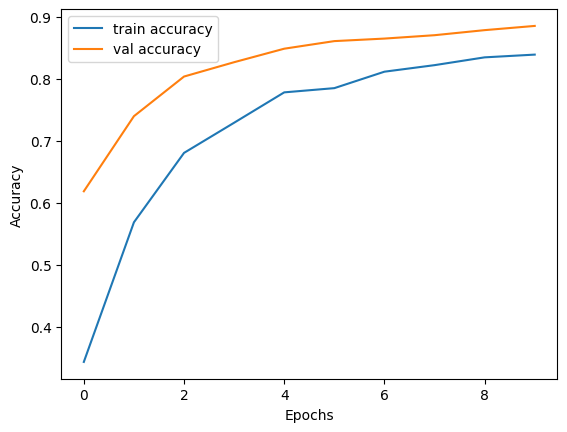

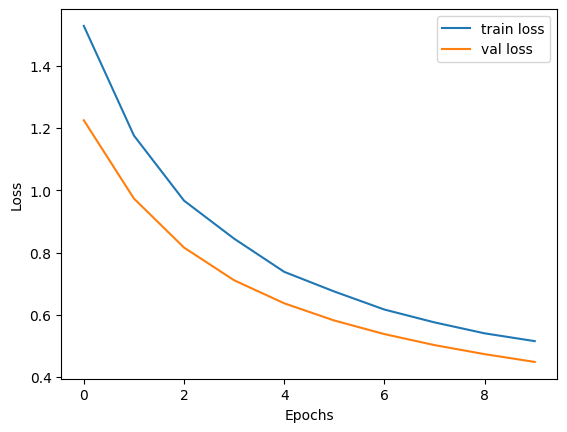

In [45]:
# Plot training curves
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


1/1 [==============================] - 1s 777ms/step


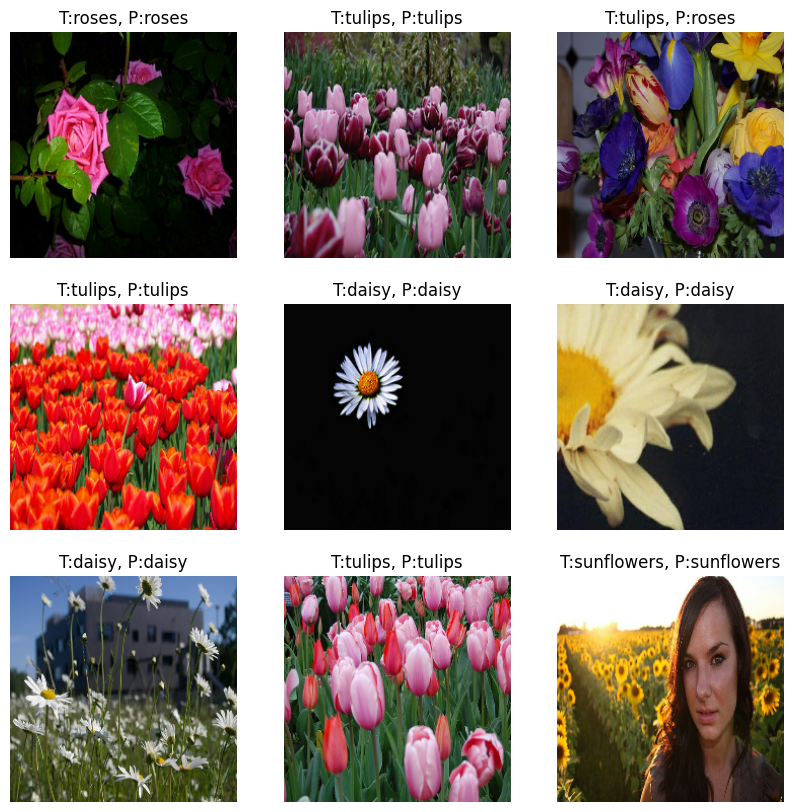

In [48]:
# Get class names
class_names = info.features["label"].names

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[pred_classes[i]]
        plt.title(f"T:{true_label}, P:{pred_label}")
        plt.axis("off")
    plt.show()
    break


